## 1. Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Time series & stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# Plot settings
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)

## 2. Load Raw Dataset

In [2]:
# Load the raw multi-category retail sales dataset
raw_path = "../data/raw/retail_salse_long_2024.csv"  # Adjust path if needed
df = pd.read_csv(raw_path)

# Display the first few rows
df.head()


,month,naics_code,kind_of_business,value
0,2024-12-01,no code,"Retail sales, total",702255.0
1,2024-06-01,no code,GAFO(1),129215.0
2,2024-01-01,no code,GAFO(1),111547.0
3,2023-12-01,451211,Book stores,1073.0
4,2023-07-01,no code,GAFO(1),128320.0


## 3. Filter Total Retail Sales

In [3]:
# Filter the dataset to keep only total retail sales
df_total = df[df["kind_of_business"] == "Retail sales, total"].copy()

df_total.head(), df_total.shape


(          month naics_code     kind_of_business     value
 0    2024-12-01    no code  Retail sales, total  702255.0
 6    2022-07-01    no code  Retail sales, total  595135.0
 9    2020-06-01    no code  Retail sales, total  478936.0
 43   2022-01-01    no code  Retail sales, total  514659.0
 134  2024-11-01    no code  Retail sales, total  641949.0,
 (396, 4))

## 4. Convert Month Column & Sort

In [4]:
# Convert 'month' to datetime and sort values
df_total["month"] = pd.to_datetime(df_total["month"])
df_total = df_total.sort_values("month")

df_total.head(), df_total.tail()


(           month naics_code     kind_of_business     value
 24799 1992-01-01    no code  Retail sales, total  130683.0
 24739 1992-02-01    no code  Retail sales, total  131244.0
 24679 1992-03-01    no code  Retail sales, total  142488.0
 24619 1992-04-01    no code  Retail sales, total  147175.0
 24559 1992-05-01    no code  Retail sales, total  152420.0,
          month naics_code     kind_of_business     value
 309 2024-08-01    no code  Retail sales, total  633664.0
 250 2024-09-01    no code  Retail sales, total  589777.0
 192 2024-10-01    no code  Retail sales, total  633013.0
 134 2024-11-01    no code  Retail sales, total  641949.0
 0   2024-12-01    no code  Retail sales, total  702255.0)

## 5. Create Monthly Time Series

In [5]:
# Keep only the time series (month - value)
ts = df_total[["month", "value"]].copy()
ts = ts.set_index("month").asfreq("MS")   # MS = Month Start

ts.head()


,value
month,
1992-01-01,130683.0
1992-02-01,131244.0
1992-03-01,142488.0
1992-04-01,147175.0
1992-05-01,152420.0


## 6. Plot Raw Time Series

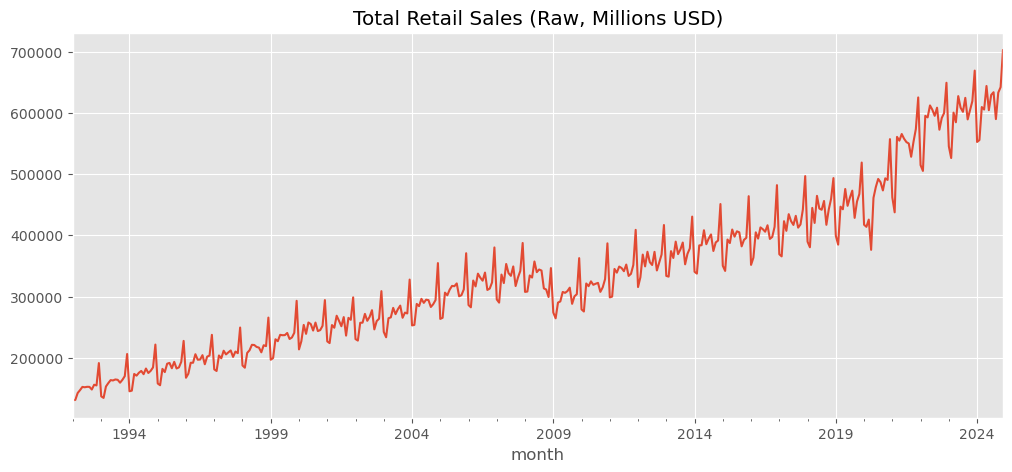

In [6]:
# Plot the raw time series
ts["value"].plot(title="Total Retail Sales (Raw, Millions USD)")
plt.show()


## 7. Save Processed Series

In [7]:
# Save the processed monthly revenue series
processed_path = "../data/processed/monthly_revenue_retail_total.csv"
ts.to_csv(processed_path)

processed_path


'../data/processed/monthly_revenue_retail_total.csv'

## 8. STL Decomposition

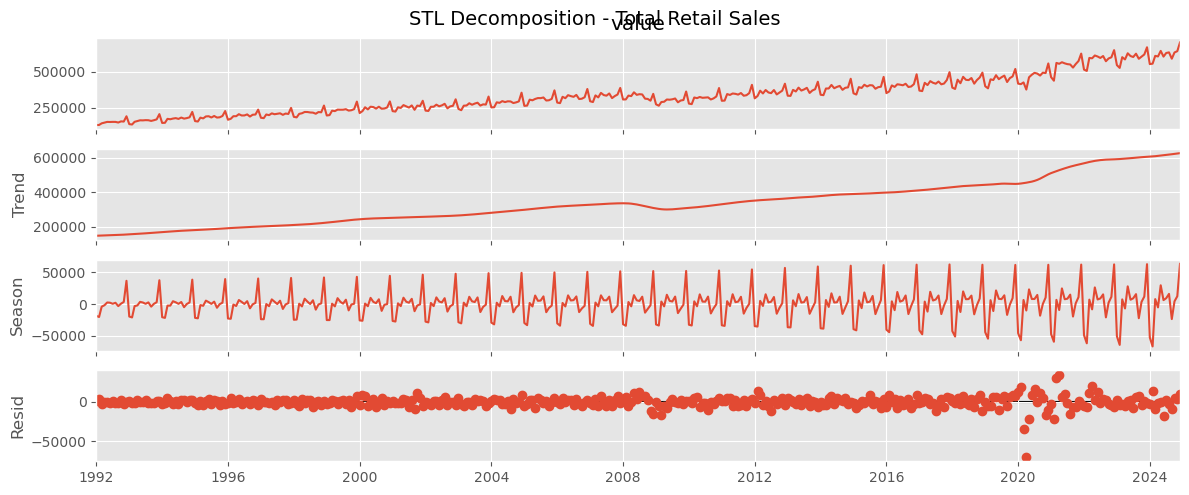

In [8]:
# STL Decomposition (Trend, Seasonality, Residual)
stl = STL(ts["value"], seasonal=13)  # 12-13 months seasonality expected
result = stl.fit()

# Plot STL components
fig = result.plot()
fig.suptitle("STL Decomposition - Total Retail Sales", fontsize=14)
plt.show()


## 9. Stationarity Test (ADF)

In [9]:
# ADF Test for stationarity
adf_result = adfuller(ts["value"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: 1.178830263757722
p-value: 0.9958363066059421


## 10. Differencing (d=1, D=1)

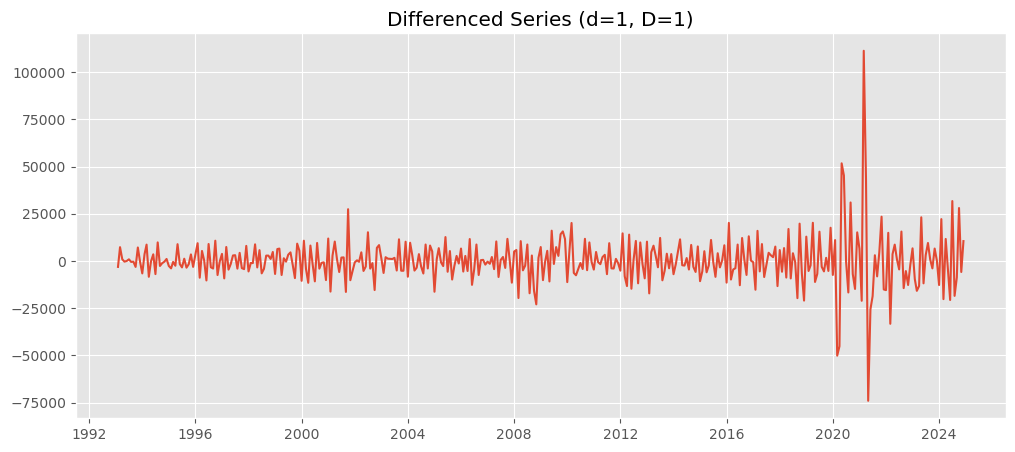

In [10]:
# Perform first differencing (d=1)
ts_diff = ts.diff().dropna()

# Perform seasonal differencing (D=1, period=12)
ts_diff_seasonal = ts_diff.diff(12).dropna()

# Plot differenced series
plt.figure(figsize=(12, 5))
plt.plot(ts_diff_seasonal)
plt.title("Differenced Series (d=1, D=1)")
plt.show()


## 11. SARIMA Parameter Search (AIC)

In [11]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import statsmodels.api as sm

# Define the p, d, q parameters
p = q = range(0, 3)
d = 1
D = 1
seasonal_period = 12

# Create all combinations for p, q
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(p, [D], q, [seasonal_period]))

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(ts,
                                              order=param,
                                              seasonal_order=seasonal_param,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
        
        except:
            continue

best_params, best_seasonal_params, best_aic


((1, 1, 2), (2, 1, 2, 12), np.float64(7606.4483804899955))

## 12. Train SARIMA Model (Train/Test Split)

In [13]:
import statsmodels.api as sm
import numpy as np

# Use best parameters from the grid search
order = (1, 1, 2)
seasonal_order = (2, 1, 2, 12)

# Train-test split: last 24 months as test set
n_test = 24
train = ts.iloc[:-n_test]
test = ts.iloc[-n_test:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Fit SARIMA model on the training data
sarima_model = sm.tsa.statespace.SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)

sarima_results.summary()


Train shape: (372, 1)
Test shape: (24, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  372
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3536.144
Date:                            Tue, 25 Nov 2025   AIC                           7088.288
Time:                                    15:27:25   BIC                           7118.729
Sample:                                01-01-1992   HQIC                          7100.428
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3309      0.214     -1.550      0.121      -0.749       0.088
ma.L1          0.0912      0.215      0.424      0.672      -0.331       0.513
ma.L2         -0.3705      0.077     -4.818      0.000      -0.521      -0.220
ar.S.L12       0.4678      0.173      2.707      0.007       0.129       0.807
ar.S.L24      -0.3755      0.096     -3.911      0.000      -0.564      -0.187
ma.S.L12      -1.0817      0.172     -6.273      0.000      -1.420      -0.744
ma.S.L24       0.4890      0.114      4.291      0.000       0.266       0.712
sigma2      1.386e+08   2.06e-09   6.74e+16      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3553.87
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.33   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.79e+33. Standard errors may be unstable.
"""

## 13. Forecast on Test Set

In [14]:
# Forecast over the test horizon
n_forecast = len(test)

forecast_obj = sarima_results.get_forecast(steps=n_forecast)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Align indexes
forecast_mean.index = test.index
forecast_ci.index = test.index

# Simple error metrics
y_true = test["value"]
y_pred = forecast_mean

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE : 18873.344496444017
RMSE: 23137.95975845734
MAPE: 3.0970667573206487


## 14. Plot Forecast vs Actual

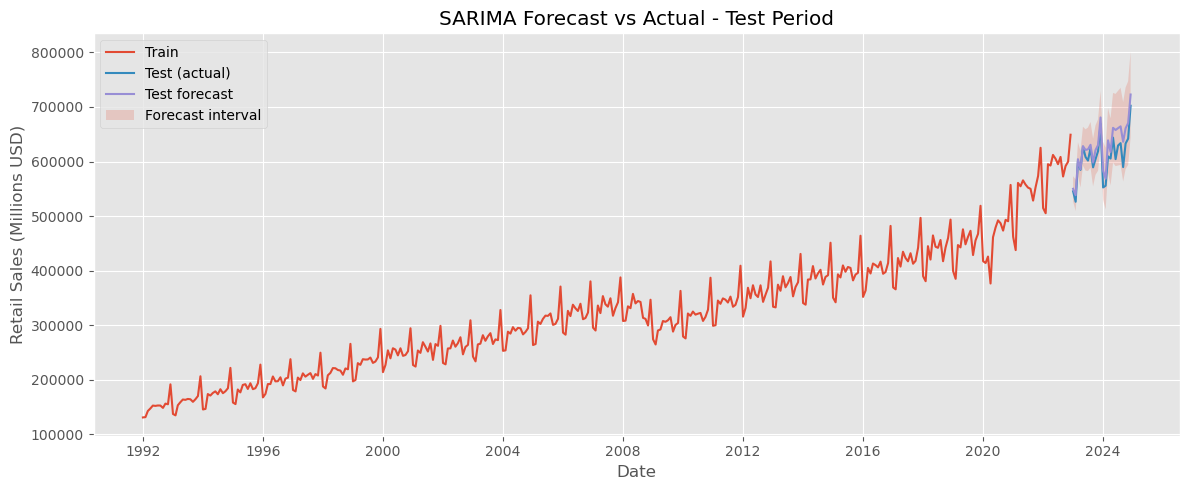

In [15]:
# Plot actual vs forecast on the test period
plt.figure(figsize=(12, 5))

plt.plot(train.index, train["value"], label="Train")
plt.plot(test.index, test["value"], label="Test (actual)")
plt.plot(forecast_mean.index, forecast_mean.values, label="Test forecast")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="Forecast interval"
)

plt.title("SARIMA Forecast vs Actual - Test Period")
plt.xlabel("Date")
plt.ylabel("Retail Sales (Millions USD)")
plt.legend()
plt.tight_layout()
plt.show()


## 15. Refit Model on Full Dataset

In [16]:
# Refit SARIMA model on the full dataset
final_model = sm.tsa.statespace.SARIMAX(
    ts,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_results = final_model.fit(disp=False)

# Forecast N future periods
n_future = 12  # you can change to 24 if you want

future_forecast_obj = final_results.get_forecast(steps=n_future)
future_mean = future_forecast_obj.predicted_mean
future_ci = future_forecast_obj.conf_int()

# Build future index manually (month start frequency)
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_future,
    freq="MS"
)

future_mean.index = future_index
future_ci.index = future_index


## 16. Final 12-Month Forecast & Save Visual

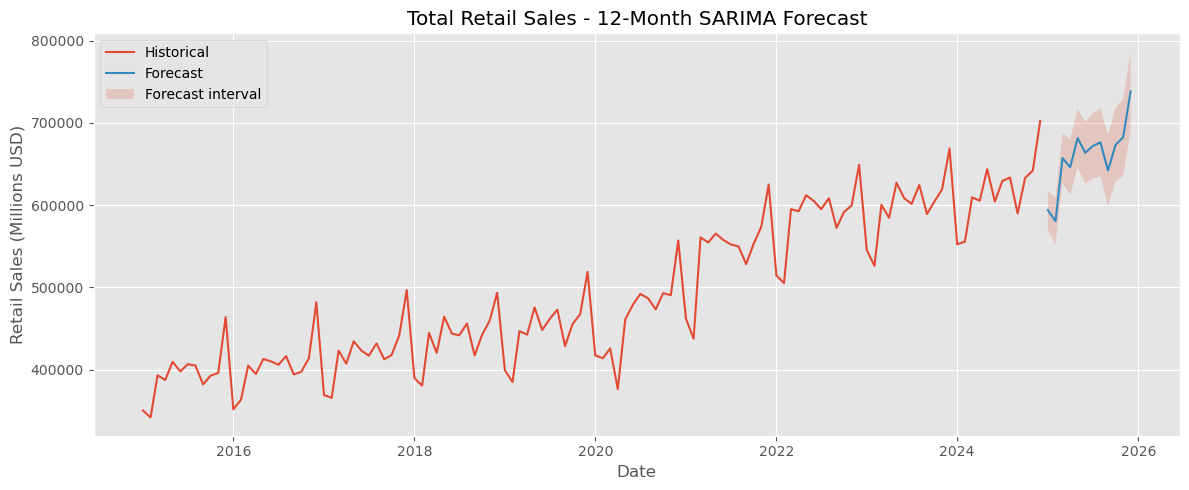

'../visuals/monthly_retail_sarima_forecast.png'

In [17]:
import os

# Make sure visuals folder exists
os.makedirs("../visuals", exist_ok=True)

# Plot last 10 years + future forecast
history_years = 10
history_start = ts.index[-history_years * 12]  # last 10 years

plt.figure(figsize=(12, 5))

plt.plot(ts.loc[history_start:].index,
         ts.loc[history_start:, "value"],
         label="Historical")

plt.plot(future_mean.index, future_mean.values, label="Forecast")

plt.fill_between(
    future_ci.index,
    future_ci.iloc[:, 0],
    future_ci.iloc[:, 1],
    alpha=0.2,
    label="Forecast interval"
)

plt.title("Total Retail Sales - 12-Month SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Retail Sales (Millions USD)")
plt.legend()
plt.tight_layout()

# Save figure to visuals folder
plot_path = "../visuals/monthly_retail_sarima_forecast.png"
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

plot_path


## 17. Save SARIMA Model Artifact (.pkl)

In [18]:
import joblib
os.makedirs("../models", exist_ok=True)

model_path = "../models/sarima_retail_total.pkl"
joblib.dump(final_results, model_path)

model_path


'../models/sarima_retail_total.pkl'

## 8. Load Trained Model and Generate Forecast (Model Artifact Demo)

## 18. Load Model Artifact & Generate Forecast

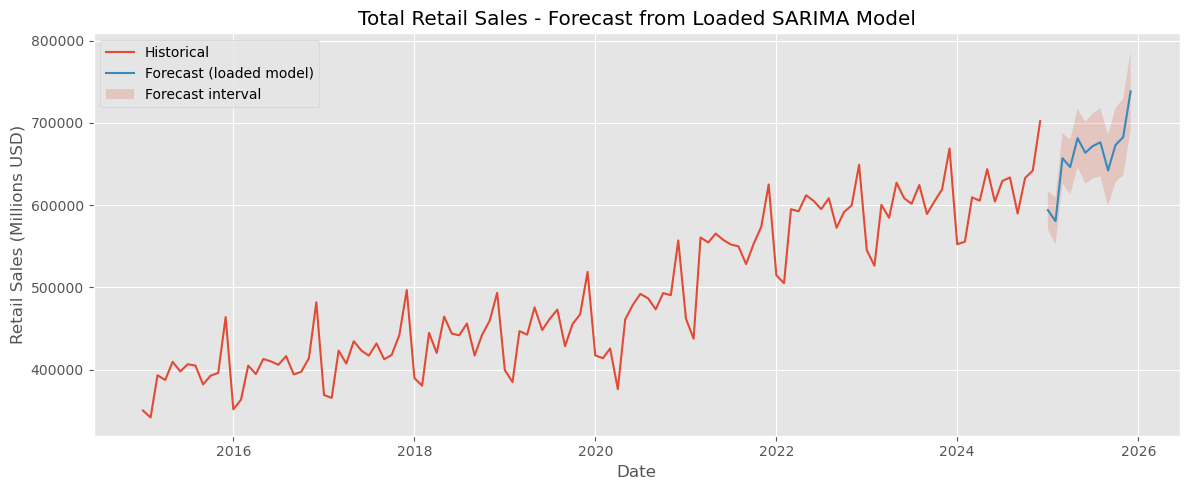

In [19]:
# Load the trained SARIMA model artifact from disk
import joblib
import pandas as pd
import matplotlib.pyplot as plt

model_path = "../models/sarima_retail_total.pkl"
loaded_results = joblib.load(model_path)

# (Optional) Load the processed time series again
ts_loaded = pd.read_csv("../data/processed/monthly_revenue_retail_total.csv",
                        parse_dates=["month"],
                        index_col="month")
ts_loaded = ts_loaded.asfreq("MS")

# Generate future forecast using the loaded model
n_future = 12  # forecast horizon in months

future_forecast_obj_loaded = loaded_results.get_forecast(steps=n_future)
future_mean_loaded = future_forecast_obj_loaded.predicted_mean
future_ci_loaded = future_forecast_obj_loaded.conf_int()

# Create future index
future_index_loaded = pd.date_range(
    start=ts_loaded.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_future,
    freq="MS"
)

future_mean_loaded.index = future_index_loaded
future_ci_loaded.index = future_index_loaded

# Plot last 10 years of history plus forecast from loaded model
history_years = 10
history_start_loaded = ts_loaded.index[-history_years * 12]

plt.figure(figsize=(12, 5))
plt.plot(ts_loaded.loc[history_start_loaded:].index,
         ts_loaded.loc[history_start_loaded:, "value"],
         label="Historical")

plt.plot(future_mean_loaded.index,
         future_mean_loaded.values,
         label="Forecast (loaded model)")

plt.fill_between(
    future_ci_loaded.index,
    future_ci_loaded.iloc[:, 0],
    future_ci_loaded.iloc[:, 1],
    alpha=0.2,
    label="Forecast interval"
)

plt.title("Total Retail Sales - Forecast from Loaded SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Retail Sales (Millions USD)")
plt.legend()
plt.tight_layout()
plt.show()
